In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-3])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/Src")

CPU times: user 199 µs, sys: 115 µs, total: 314 µs
Wall time: 252 µs


# Import Agulhas Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../Data/Agulhas_AVISO.mat')

#mat_file = sio.loadmat('../../../Data/DataTRAPs.mat')

print(mat_file.keys())

U = mat_file['u'] #u
V = mat_file['v'] #v
x = mat_file['x'] #x
y = mat_file['y'] #y
time = mat_file['t']

dict_keys(['__header__', '__version__', '__globals__', 'u', 'v', 'x', 'y', 't'])
CPU times: user 165 ms, sys: 54.3 ms, total: 219 ms
Wall time: 225 ms


# Data/Parameters for Dynamical System

In [3]:
%%time
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 18

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

CPU times: user 234 µs, sys: 58 µs, total: 292 µs
Wall time: 263 µs


# Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# domain boundaries (in degrees)
xmin = 2
xmax = 7
ymin = -38
ymax = -33

# spacing of meshgrid (in degrees)
dx = 0.05
dy = 0.05

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Summarize spatio-temporal domain of dynamical system
params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *
DS = Dynamical_System(params_data, params_DS)

CPU times: user 419 ms, sys: 109 ms, total: 527 ms
Wall time: 552 ms


## Velocity Interpolation

In [5]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 97.6 ms, sys: 9.95 ms, total: 108 ms
Wall time: 108 ms


# Rate of strain tensor

In [6]:
%%time
from tqdm.notebook import tqdm

# Define Rate of Strain over meshgrid (Ny, Nx, 2, 2)
S = np.zeros((X_domain.shape[0], X_domain.shape[1], 2, 2))*np.nan

# Iterate over meshgrid
for i in tqdm(range(X_domain.shape[0])):
    
    for j in range(X_domain.shape[1]):
        
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        # Compute rate of strain
        S[i, j,:,:] = DS._spin_tensor(x, t_OECS)

  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: user 4.58 s, sys: 952 ms, total: 5.54 s
Wall time: 4.78 s


# Tensorfield properties

In [7]:
# Import function which calculates tensorfield properties
from ipynb.fs.defs.tensorfield import _tensorfield

# Compute tensorfield properties (eigenvalue, eigenvector, derivatives of components of rate of strain tensor)
X_domain, Y_domain, s1, s2, v1, v2, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y = _tensorfield(X_domain, Y_domain, S, type = 'OECS')

## Interpolate $ \dot{\phi}(x, y, \phi), s_1(x, y), s_2(x, y) $ 

In [8]:
%%time
from ipynb.fs.defs.phi_prime_OECS import _phi_prime_OECS

# Interpolant phi_phrime
interp_phi_prime_attracting = _phi_prime_OECS(X_domain, Y_domain, s2, S11x, S11y, S12x, S12y, S22x, S22y, Ncores)

# Interpolant phi_phrime
interp_phi_prime_repelling = _phi_prime_OECS(X_domain, Y_domain, s1, S11x, S11y, S12x, S12y, S22x, S22y, Ncores)

# Interpolant s1
from scipy.interpolate import RectBivariateSpline as RBS
interp_s1 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(s1, nan = 0), kx=1, ky=1)

# Interpolant s2
interp_s2 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(s2, nan = 0), kx=1, ky=1)

CPU times: user 29 s, sys: 178 ms, total: 29.2 s
Wall time: 6.79 s


# Find objective Saddle-points

In [9]:
from ipynb.fs.defs.loc_max import _loc_max

# minimum distance between objective saddles (=local maxima in the s2-field)
min_distance = .1

# indices, positions and value (of s2-field) of the objective saddles
loc_idx_x, loc_idx_y, loc_max_x, loc_max_y, loc_max_field = _loc_max(min_distance, X_domain, Y_domain, s2)

  0%|          | 0/29 [00:00<?, ?it/s]

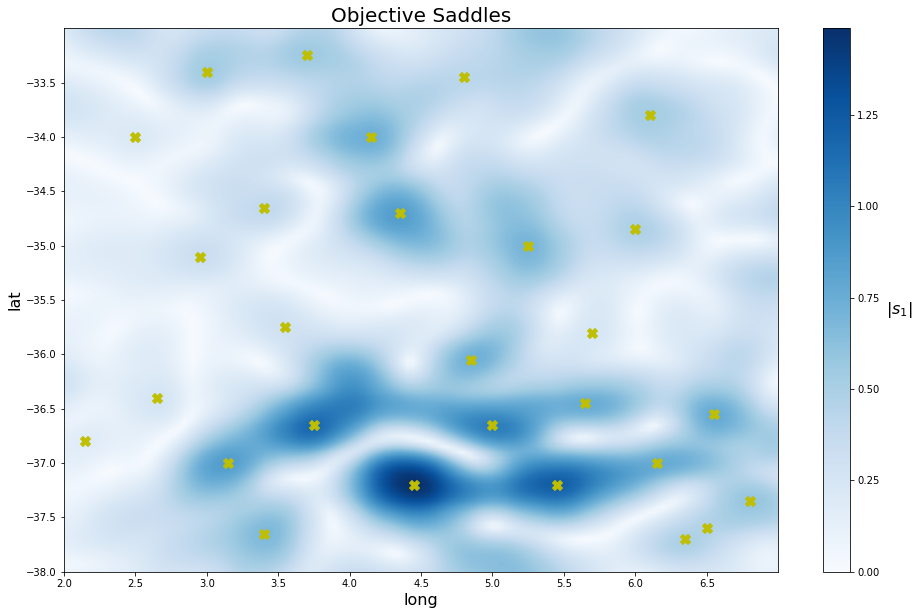

In [10]:
###################################### PLOT OBJECTIVE SADDLES ######################################
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()

cax = ax.contourf(X_domain, Y_domain, s2, levels = 400, cmap = "Blues")

ax.scatter(loc_max_x, loc_max_y, c = 'y', marker = "X", s = 100)
    
ax.set_xlabel('long', fontsize = 16)
ax.set_ylabel('lat', fontsize = 16)

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), .5))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), .5))

ax.set_title('Objective Saddles', fontsize = 20)

cbar = plt.colorbar(cax)
cbar.set_ticks(np.arange(0, 1.5, 0.25))
cbar.set_label(r'$ |s_1| $', rotation = 0, labelpad = 20, fontsize = 16)

plt.show()

# Compute Initial Conditions ($ x_0, y_0, \phi_0 $) for Hyperbolic OECS

In [11]:
from math import atan, cos, sin

# initial positions from where to start integration of hyperbolic OECS
x0s1 = loc_max_x
y0s1 = loc_max_y

# Choose vector-field
v = v2.copy()
phi0s1_repelling, phi0s1_attracting = [], []

for i in range(len(loc_idx_x)):
    eigenvector = v[loc_idx_y[i], loc_idx_x[i], :]
    angle = atan(eigenvector[1]/eigenvector[0])%(2*np.pi)
    phi0s1_repelling.append(angle - np.pi/2)
    phi0s1_attracting.append(angle)

# Compute Attracting/Repelling OECS

In [ ]:
from scipy.integrate import solve_ivp
from ipynb.fs.defs.tensorline_equation import _tensorline_equation
from ipynb.fs.defs.extract_hyperbolic_OECS import _extract_hyperbolic_OECS

# define domain where velocity field is defined
defined_domain = np.isfinite(s2).astype(int)

# If tensorline is close to singularity 
# --> integration stops as eigenvector are no longer well defined.
# set threshold on rate of attraction which controls stopping criterion of integration.
s_threshold = 0.001

# define lists containing the position and the rate of attracion/repulsion along 
# unstable/stable segments of the hyperbolic OECS
x_attracting, y_attracting, s_attracting = [], [], []
x_repelling, y_repelling, s_repelling = [], [], []

# objective saddle location
objective_saddle = []

# Iterate over objective saddle-points (hyperbolic OECS)
for i in tqdm(range(len(x0s1))):
    
    # backward (-1) and forward (+1) integration
    for sign in [-1, 1]:
        
        # Append objective saddle
        objective_saddle.append([x0s1[i], y0s1[i]])
        
        # define integration interval of dummy variable 's'
        t = [0, sign*5]
        
        # define resolution of stable/unstable segments of hyperbolic OECS
        t_eval = np.linspace(t[0], t[1], 1000)

        # IC repelling OECS
        x0_repelling = [x0s1[i], y0s1[i], phi0s1_repelling[i]]
        
        # IC repelling OECS
        x0_attracting = [x0s1[i], y0s1[i], phi0s1_attracting[i]]
        
        # solve ODE for repelling OECS
        solREP = solve_ivp(_tensorline_equation, t, x0_repelling, 'BDF', t_eval, rtol=1e-8, atol=1e-8, args=(interp_phi_prime_repelling, s_threshold, interp_s1, X_domain, Y_domain, defined_domain))         
        
        # solve ODE for attracting OECS
        solATTR = solve_ivp(_tensorline_equation, t, x0_attracting, 'BDF', t_eval, rtol=1e-8, atol=1e-8, args=(interp_phi_prime_attracting, s_threshold, interp_s2, X_domain, Y_domain, defined_domain))   
        
        # extract attracting/repelling segments from the solution of the ODE as those segments
        # where the rate of attraction/repulsion |s1|=|s2| is monotonically decreasing
        x_repelling_OECS, y_repelling_OECS, s_repelling_OECS = _extract_hyperbolic_OECS(solREP.y[0,:], solREP.y[1,:], interp_s1) 
        x_attracting_OECS, y_attracting_OECS, s_attracting_OECS = _extract_hyperbolic_OECS(solATTR.y[0,:], solATTR.y[1,:], interp_s1) 
        
        x_attracting.append(x_attracting_OECS)
        y_attracting.append(y_attracting_OECS)
        s_attracting.append(s_attracting_OECS)
        
        x_repelling.append(x_repelling_OECS)
        y_repelling.append(y_repelling_OECS)
        s_repelling.append(s_repelling_OECS)

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
################################ PLOT HYPERBOLIC OECS ################################

import matplotlib.pyplot as plt

# generate figure and axis object
fig = plt.figure(figsize = (16, 12))
ax = plt.axes()

# Plot s2-field
cax = ax.contourf(X_domain, Y_domain, s2, levels = 600, cmap = "gist_rainbow_r")

cbar = plt.colorbar(cax)
cbar.set_ticks(np.arange(0, 1.5, 0.25))
cbar.set_label(r'$ |s_1| $', rotation = 0, labelpad = 20, fontsize = 16)

# Plot attracting OECS
for i in range(len(x_attracting)):
    ax_attracting = ax.plot(x_attracting[i], y_attracting[i], c = "k", linewidth = 2.5)

# Plot repelling OECS
for j in range(len(x_repelling)):
    ax_repelling = ax.plot(x_repelling[j], y_repelling[j], c = "w", linewidth = 2.5)

# set limits
ax.set_xlim(np.min(X_domain), np.max(X_domain))
ax.set_ylim(np.min(Y_domain), np.max(Y_domain))

# plot e2 vector-field
ax.quiver(X_domain[::4,::4], Y_domain[::4,::4], v2[::4,::4,0], v2[::4,::4,1])

# Set title
ax.set_title('Repelling/Attracting OECSs from Fast Computation of Tensorlines (FCOT)', fontsize = 20)

# Plot legend
import matplotlib.patches as mpatches
attracting = mpatches.Patch(color='k', label='attracting OECS')
repelling = mpatches.Patch(color='w', label='repelling OECS')
plt.legend(handles=[attracting, repelling], fontsize = 16)
 
# Show plot
plt.show()

# Validation of Tensorline-calculation

In [ ]:
## This function evaluates the oriented vector-field at point x

def _orient_vector_field(X, Y, x, vector_field):
    
        # import Rectangular bivariate spline from scipy
        from scipy.interpolate import RectBivariateSpline as RBS
            
        # Check for orientational discontinuity by introducing appropriate scaling
        idx_x = np.searchsorted(X[0,:], x[0])
        idx_y = np.searchsorted(Y[:,0], x[1])
        
        if 0 < idx_x < X.shape[1] and 0 < idx_y < Y.shape[0]:
    
            X_reduced, Y_reduced = X[idx_y-1:idx_y+1, idx_x-1:idx_x+1], Y[idx_y-1:idx_y+1, idx_x-1:idx_x+1]
    
            vx_grid = np.array([[vector_field[idx_y-1,idx_x-1, 0], vector_field[idx_y, idx_x-1, 0]],
                      [vector_field[idx_y-1,idx_x, 0], vector_field[idx_y, idx_x, 0]]])
            vy_grid = np.array([[vector_field[idx_y-1,idx_x-1, 1], vector_field[idx_y, idx_x-1, 1]],
                      [vector_field[idx_y-1,idx_x, 1], vector_field[idx_y, idx_x, 1]]])
        
            for i in range(2):
                for j in range(2):
                    if vx_grid[0, 0]*vx_grid[i, j]+vy_grid[0, 0]*vy_grid[i, j] < 0:
                        vx_grid[i, j] = -vx_grid[i, j]
                        vy_grid[i, j] = -vy_grid[i, j]
    
            vx_Interp = RBS(Y_reduced[:,0], X_reduced[0,:], vx_grid, kx = 1, ky = 1)
            vy_Interp = RBS(Y_reduced[:,0], X_reduced[0,:], vy_grid, kx = 1, ky = 1)
        
            return vx_Interp(x[1], x[0])[0][0], vy_Interp(x[1], x[0])[0][0]
        
        else:
            
            return None, None

## Validation of attracting OECS

In [ ]:
distance = []
diff_phi = []

for i in range(len(x_attracting)):
    for j in range(1, len(x_attracting[i])-1):
        
        dy = y_attracting[i][j+1]-y_attracting[i][j-1]
        dx = x_attracting[i][j+1]-x_attracting[i][j-1]
        
        phi = atan(dy/dx)
        
        x = [x_attracting[i][j], y_attracting[i][j]]
        
        # evaluate oriented vector field v2 at x
        vector = _orient_vector_field(X_domain, Y_domain, x, v2)
        
        if vector[0] is not None:
            dy_oriented = vector[1]
            dx_oriented = vector[0]
        
            phi_True = atan(dy_oriented/dx_oriented)
            
            diff_phi.append(min(np.abs(-phi-phi_True), np.abs(phi-phi_True))/(np.pi/2))
            
            distance.append(sqrt((x[0]-objective_saddle[i][0])**2+(x[1]-objective_saddle[i][1])**2))
           

In [ ]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes()

ax.set_title(r'Error of $ \phi $ vs distance from core of saddle for attracting OECS', fontsize = 16)

ax.scatter(distance, diff_phi, marker = "^", s = 10)

ax.set_ylabel(r'$ \dfrac{|\phi-\phi_{oriented}|}{\pi/2} $', fontsize = 16)
ax.set_xlabel("distance from core of saddle (deg)", fontsize = 16)

ax.text(0, 0.7, r'$ \dfrac{|\phi-\phi_{oriented}|}{\pi/2} < .1$: '+str(np.around(len([i for i in diff_phi if i < .1])/len(diff_phi),2)*100)+r'%', fontsize = 16)
ax.text(0, 0.6, r'$ \dfrac{|\phi-\phi_{oriented}|}{\pi/2} < .05$: '+str(np.around(len([i for i in diff_phi if i < .05])/len(diff_phi),2)*100)+r'%', fontsize = 16)
ax.text(0, 0.5, r'$ \dfrac{|\phi-\phi_{oriented}|}{\pi/2} < .01$: '+str(np.around(len([i for i in diff_phi if i < .01])/len(diff_phi),2)*100)+r'%', fontsize = 16)
plt.show()

## Validation of repelling OECS

In [ ]:
distance = []
diff_phi = []

for i in range(len(x_repelling)):
    for j in range(1, len(x_repelling[i])-1):
        
        dy = y_repelling[i][j+1]-y_repelling[i][j-1]
        dx = x_repelling[i][j+1]-x_repelling[i][j-1]
        
        phi = atan(dy/dx)
        
        x = [x_repelling[i][j], y_repelling[i][j]]
        
        # evaluate oriented vector field v2 at x
        vector = _orient_vector_field(X_domain, Y_domain, x, v1)
        
        if vector[0] is not None:
            dy_oriented = vector[1]
            dx_oriented = vector[0]
        
            phi_True = atan(dy_oriented/dx_oriented)
            
            diff_phi.append(min(np.abs(-phi-phi_True), np.abs(phi-phi_True))/(np.pi/2))
            
            distance.append(sqrt((x[0]-objective_saddle[i][0])**2+(x[1]-objective_saddle[i][1])**2))
           

In [ ]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes()

ax.set_title(r'Error of $ \phi $ vs distance from core of saddle for repelling OECS', fontsize = 16)

ax.scatter(distance, diff_phi, marker = "^", s = 10)

ax.set_ylabel(r'$ \dfrac{|\phi-\phi_{oriented}|}{\pi/2} $', fontsize = 16)
ax.set_xlabel("distance from core of saddle (deg)", fontsize = 16)

ax.text(0, 0.7, r'$ \dfrac{|\phi-\phi_{oriented}|}{\pi/2} < .1$: '+str(np.around(len([i for i in diff_phi if i < .1])/len(diff_phi),2)*100)+r'%', fontsize = 16)
ax.text(0, 0.6, r'$ \dfrac{|\phi-\phi_{oriented}|}{\pi/2} < .05$: '+str(np.around(len([i for i in diff_phi if i < .05])/len(diff_phi),2)*100)+r'%', fontsize = 16)
ax.text(0, 0.5, r'$ \dfrac{|\phi-\phi_{oriented}|}{\pi/2} < .01$: '+str(np.around(len([i for i in diff_phi if i < .01])/len(diff_phi),2)*100)+r'%', fontsize = 16)
plt.show()